# Análise das notícias sob a ótica ESG 

In [6]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import datetime  as dt
from scipy import interpolate
import scipy.stats
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from noticias_timeline import plota_timeline
from noticias_processamento_texto import remove_acentos, remove_termos_comuns, aplica_stemming_texto, remove_palavras_texto, conta_termos_esg, classifica_texto, classifica_textos_coletados, filtra_noticias_nao_relacionadas, filtra_noticias_sem_classificacao, conta_mencoes_empresas, filtra_citacao_relevante, trim_texto
from vaderSentimentptbr import SentimentIntensityAnalyzer 
from sumarizador_textrankptbr import summarize_text_rank 
from analise_sentimento_modelo import filtrar_noticias_pos_coleta, gera_curva_polaridade_media, pondera_polaridade_titulo_texto
import re


warnings.filterwarnings('ignore')
base_noticias = 'datasets/base_noticias.xlsx'
base_noticias_saida = 'datasets/sentimento_base_noticias.xlsx'
df = pd.read_excel(base_noticias)

## Pré-processamento da base de notícias
- Realiza filtro
- Resume o texto pelo algoritmo TextRank (Mihalcea, 2014): https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

In [7]:
# filtros pos processamento (exclusoes)
df = filtrar_noticias_pos_coleta(df)

# resume o texto filtrando partes nao relevantes
df['resumo'] = df['texto_completo'].apply(lambda x : summarize_text_rank(x, compression=0.8, include_first_parag=True))

## Aplicação do algoritmo de análise de sentimento VADER adaptado ao português
Referências:
Gilbert, CJ Hutto Eric. 2014. Vader: A parsimonious rule-based model for sentiment analysis of social media text.
Eighth International Conference on Weblogs and Social Media (ICWSM-14). Disponível em: <http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf>


In [8]:
s = SentimentIntensityAnalyzer() 
df['polaridade_texto'] = df['resumo'].apply(lambda x : s.polarity_scores(x)['compound'] )
df['polaridade_titulo'] = df['titulo'].apply(lambda x : s.polarity_scores(x)['compound'] )

# pondera heuristicamente titulo e texto
df['polaridade'] = pondera_polaridade_titulo_texto(df['polaridade_titulo'] , df['polaridade_texto'])


df.to_excel(base_noticias_saida, index=False)

## Descrevendo o conjunto de dados

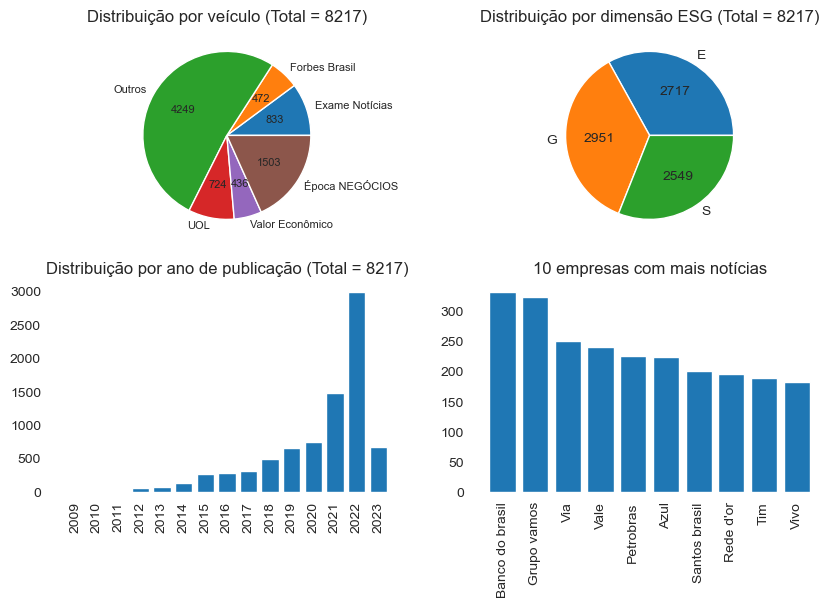

In [9]:
df = pd.read_excel(base_noticias_saida)
sns.set_style("white")
# agrupando por fonte, dimensao e datas
dfFontes  = df.groupby("fonte").count().reset_index(drop=False)
dfFontes['fonte'] = dfFontes.apply(lambda row : 'Outros' if row['titulo'] < 0.03 * np.sum(dfFontes['titulo']) else row['fonte'] , axis=1)
dfFontes  = dfFontes.groupby("fonte").sum() 
dfDimensoes  = df.groupby("classificacao").count()
dfAnos = df.set_index("data_publicacao").groupby([pd.Grouper(freq="Y")]).count().sort_index()
dfEmpresas  = df.groupby("empresa").count().sort_values(by=['titulo'], ascending=False).reset_index(drop=False)

plt.figure(figsize = (10, 6))
plt.subplot(2, 2, 1)
plt.pie(dfFontes['titulo'], labels=dfFontes.index, autopct=lambda p: '{:.0f}'.format(p * np.sum(dfFontes['titulo']) / 100),  textprops={'fontsize': 8})
plt.title('Distribuição por veículo (Total = '  + str(np.sum(dfFontes['titulo']))+ ')' )

plt.subplot(2, 2, 2)
plt.pie(dfDimensoes['titulo'], labels=dfDimensoes.index, autopct=lambda p: '{:.0f}'.format(p * np.sum(dfDimensoes['titulo']) / 100))
plt.title('Distribuição por dimensão ESG (Total = '  + str(np.sum(dfDimensoes['titulo']))+ ')' )

plt.subplot(2, 2, 3)
y_pos = np.arange(len(dfAnos.index))
plt.bar(y_pos, dfAnos['titulo']  )
plt.box(False)
plt.xticks(y_pos, dfAnos.index.year, rotation=90)
plt.title('Distribuição por ano de publicação (Total = '  + str(np.sum(dfDimensoes['titulo']))+ ')' )

plt.subplot(2, 2, 4)
y_pos = np.arange(10)
plt.bar(y_pos, dfEmpresas.head(10)['titulo']  )
plt.box(False)
plt.xticks(y_pos, dfEmpresas.head(10)['empresa'].str.capitalize(), rotation=90)
plt.title('10 empresas com mais notícias' )

plt.savefig(r'static/images/descricao_base.png', bbox_inches='tight')
plt.show()

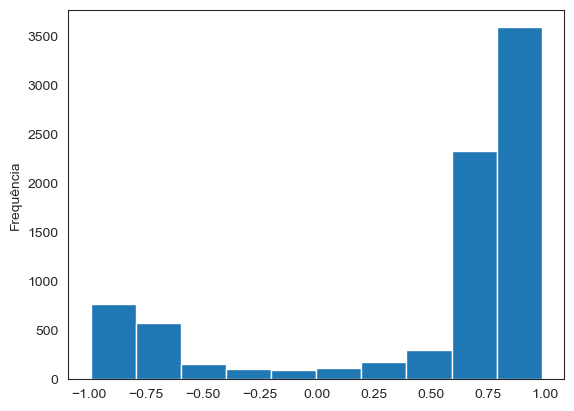

In [10]:
df['polaridade'].plot.hist().set_ylabel('Frequência')
plt.savefig(r'static/images/histograma_base.png', bbox_inches='tight')
plt.show()

## Definindo a empresa para análise específica

In [11]:
empresa = 'banco btg pactual'
dfEmpresa = df[df['empresa'] == empresa]

## Análise de frequencia e distribuição para a empresa

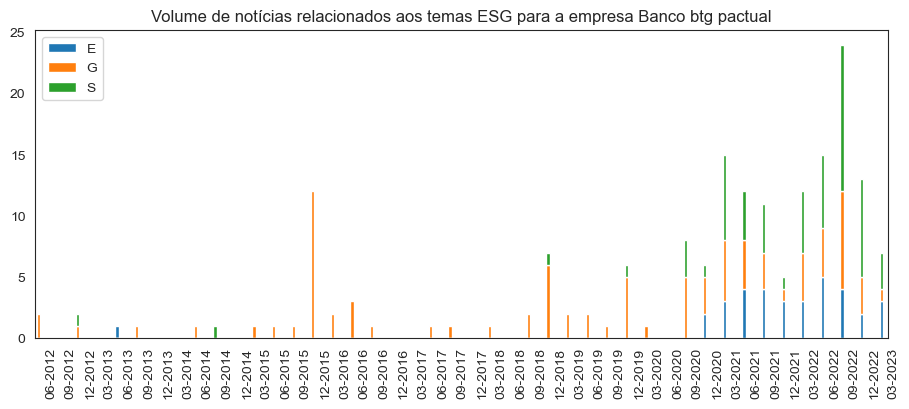

In [12]:
# agrupamento dos dados por data e categoria

dfCategoria = dfEmpresa.set_index("data_publicacao").groupby([pd.Grouper(freq="Q"), "classificacao"]).count()

# criação do gráfico de barras empilhadas
dfCategoria = dfCategoria['titulo'].unstack()  
dfCategoria = dfCategoria.asfreq('M')
ax = dfCategoria.plot.bar( stacked=True, figsize=(11,4))
ax.legend(title='')
labels = [tick.strftime('%m-%Y') if tick.month%3==0 else '' for tick in dfCategoria.index ]
ax.set_xticks(np.linspace(start=1, stop=len(labels), num=len(labels)))
ax.set_xticklabels(labels, rotation=90, ha='left')
ax.set_xlabel('')
ax.set_title('Volume de notícias relacionados aos temas ESG para a empresa '+empresa.capitalize())
plt.savefig(r'images/distribuicao_qtde_empresa.png', bbox_inches='tight')
plt.show()

## Visualização do sentimento para a empresa

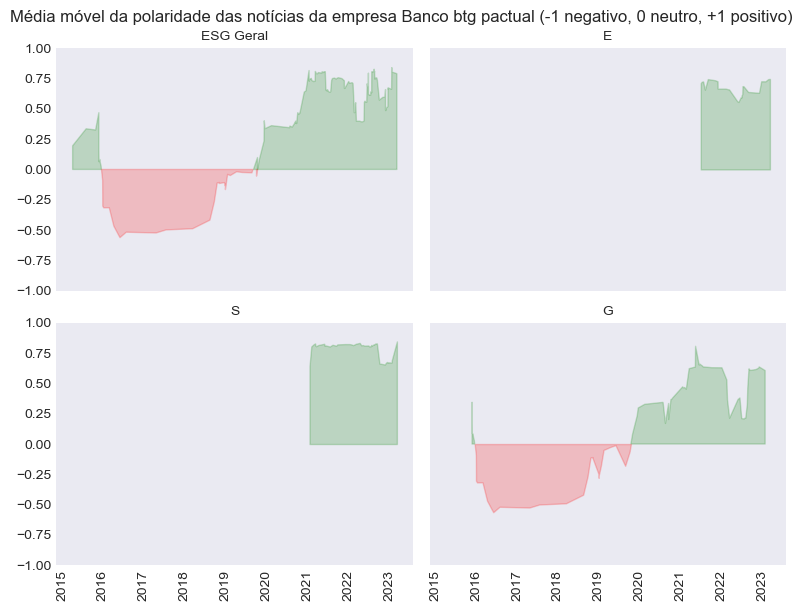

In [13]:
plt.style.use('seaborn-dark')

ldfVisoesESG = [dfEmpresa]
llabelVisoesESG = ['ESG Geral']

for l in 'ESG':
    ldfVisoesESG.append(dfEmpresa[dfEmpresa['classificacao'] == l])
    llabelVisoesESG.append(l)
for d in ldfVisoesESG:
    d['media'] = d.rolling(10)['polaridade'].mean()
    
# plotando o gráfico com a média móvel
fig, ax = plt.subplots(2,2, figsize=(8, 6), sharex=True, sharey=True)
l = 0
for i in range(0,2):
    for j in range (0,2):
        ax[i,j].plot(ldfVisoesESG[l]['data_publicacao'], ldfVisoesESG[l]['media'], label='Média Móvel', color='black', linewidth=0)
        # ajustando o visual do gráfico
        ax[i,j].set_title(llabelVisoesESG[l], fontsize=10)
        ax[i,j].fill_between(ldfVisoesESG[l]['data_publicacao'], 0 , ldfVisoesESG[l]['media'], interpolate=True, where=ldfVisoesESG[l]['media']>0, color='green', alpha=0.2)
        ax[i,j].fill_between(ldfVisoesESG[l]['data_publicacao'], 0 , ldfVisoesESG[l]['media'], interpolate=True,  where=ldfVisoesESG[l]['media']<0, color='red', alpha=0.2)
        ax[i,j].tick_params(axis='x', labelrotation=90)
        l = l+1
plt.tight_layout()
plt.ylim(-1, 1)
fig.suptitle('Média móvel da polaridade das notícias da empresa '+empresa.capitalize()+' (-1 negativo, 0 neutro, +1 positivo)', y=1.01)
plt.savefig(r'static/images/media_movel_empresa.png', bbox_inches='tight')
plt.show()

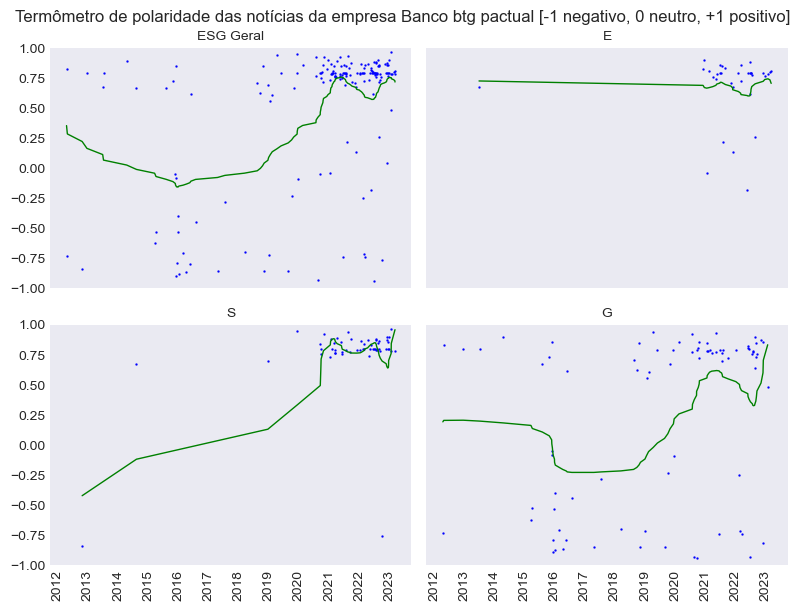

In [14]:
dfPolaridade = dfEmpresa

# plota grafico polaridade media

plt.style.use('seaborn-dark')

ldfVisoesESG = [gera_curva_polaridade_media(df, empresa, 'ESG')]
llabelVisoesESG = ['ESG Geral']

for l in 'ESG':
    ldfVisoesESG.append( gera_curva_polaridade_media(df, empresa, l)  )
    llabelVisoesESG.append(l)
    
# plotando o gráfico com a interpolação
fig, ax = plt.subplots(2,2, figsize=(8, 6), sharex=True, sharey=True)
l = 0
for i in range(0,2):
    for j in range (0,2):
        if ldfVisoesESG[l] is not None and len(ldfVisoesESG[l]) > 0:
            ax[i,j].plot(ldfVisoesESG[l].index, ldfVisoesESG[l]['polaridade_fit'], label='Interpolação', color='green', linewidth=1)
            #ax[i,j].plot(ldfVisoesESG[l].index, ldfVisoesESG[l]['polaridade_ewma'], label='EWMA', color='black', linewidth=0.4)
            ax[i,j].scatter(ldfVisoesESG[l].index, ldfVisoesESG[l]['polaridade'], label='Ponto', s=2, color='blue', linewidth=0.2)
            # ajustando o visual do gráfico
            ax[i,j].set_title(llabelVisoesESG[l], fontsize=10)
            ax[i,j].tick_params(axis='x', labelrotation=90)
            ax[i,j].xaxis.set_major_locator(YearLocator() )
            ax[i,j].xaxis.set_major_formatter(DateFormatter('%Y'))
            ax[i,j].xaxis.set_minor_locator(MonthLocator())
        l = l+1
plt.tight_layout()
plt.ylim(-1, 1)
fig.suptitle('Termômetro de polaridade das notícias da empresa '+empresa.capitalize()+' [-1 negativo, 0 neutro, +1 positivo]', y=1.01)
plt.savefig(r'static/images/ewma_polaridade_empresa.png', bbox_inches='tight')
plt.show()


### Comparativo EWMA x pontos

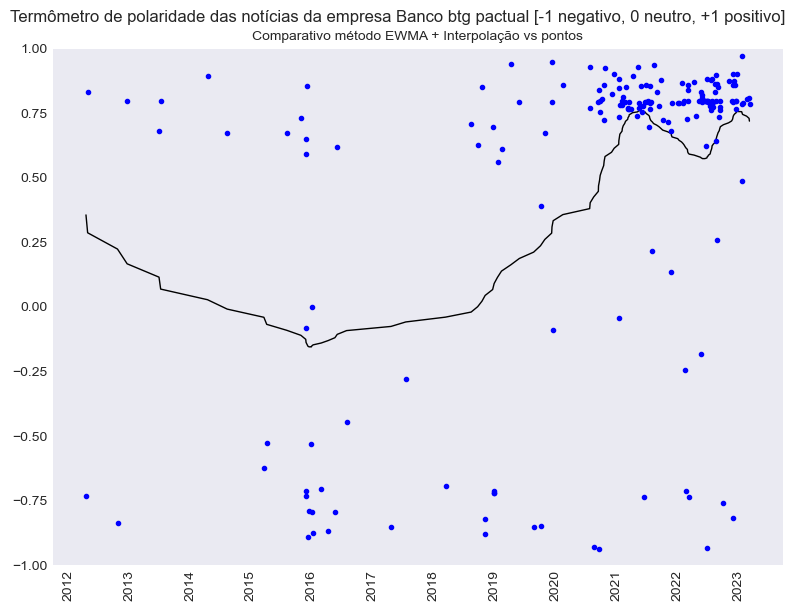

In [15]:
dfEWMA = gera_curva_polaridade_media(df, empresa, 'ESG')
dfPontos = df[df.empresa == empresa]

fig, ax = plt.subplots(1,1, figsize=(8, 6), sharex=True, sharey=True)
ax.plot(dfEWMA.index, dfEWMA['polaridade_fit'], label='Média Móvel', color='black', linewidth=1)
ax.plot(dfPontos['data_publicacao'], dfPontos['polaridade'], '.', label='Ponto', color='blue', linewidth=1)
# ajustando o visual do gráfico
ax.set_title('Comparativo método EWMA + Interpolação vs pontos', fontsize=10)
ax.tick_params(axis='x', labelrotation=90)
ax.xaxis.set_major_locator(YearLocator() )
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_minor_locator(MonthLocator())

plt.tight_layout()
plt.ylim(-1, 1)
fig.suptitle('Termômetro de polaridade das notícias da empresa '+empresa.capitalize()+' [-1 negativo, 0 neutro, +1 positivo]', y=1.01)
plt.savefig(r'static/images/comparativo_ponto_ewma.png', bbox_inches='tight')
plt.show()


## Amostra de notícias para a empresa

In [16]:
plt.style.use('seaborn-white')

def plota_timeline_polaridade(dfEmpresa, sinal, numero_noticias=2, empresa=''):
    desc = ''
    dfTimeline = dfEmpresa
    if sinal >0:
        dfTimeline = dfEmpresa[dfEmpresa['polaridade'] > 0]
        desc = 'positivas'
    else:
        dfTimeline = dfEmpresa[dfEmpresa['polaridade'] < 0]
        desc = 'negativas'
        
    dfTimeline = dfTimeline.sort_values('polaridade',ascending = False).groupby(dfTimeline.data_publicacao.dt.date).head(1).sort_values(by='data_publicacao')
    dfTimeline = dfTimeline.sort_values('polaridade',ascending = False).groupby(dfTimeline.data_publicacao.dt.year).head(numero_noticias).sort_values(by='data_publicacao')
    dates = list(dfTimeline['data_publicacao'].dt.date)
    labels = list(dfTimeline.apply(lambda row : row['titulo'] + ' [' + row['classificacao']   + ' ' + '{:.2f}'.format(row['polaridade']) +   ']'    , axis=1))
    labels = [trim_texto(l) for l in labels]
    
    for d, l in zip(dates, labels):
        print(d.strftime("%d/%m/%Y") + ": " + l)

    plota_timeline(dates, labels, 'Timeline de amostra de noticias ' + desc + ' para empresa '+ empresa.capitalize() + ' (2 notícias/ano)')

26/04/2012: Recursos do IPO do BTG irão para ampliar negócios - Época NEGÓCIOS [G 0.83]
19/12/2012: 12 brasileiros que se destacaram em 2012 - Época NEGÓCIOS [G 0.80]
28/06/2013: BTG Pactual ofereceu US$ 1 bilhão por mineradora para juntá-la à MMX - Época NEGÓCIOS [E 0.68]
08/07/2013: A turma do interior - Época NEGÓCIOS [G 0.80]
15/04/2014: Ele não é da NASA. Mas adora pôr foguetes no ar - Época NEGÓCIOS [G 0.90]
11/08/2014: BTG quer ser mais do que um banco global - Época NEGÓCIOS [S 0.67]
27/10/2015: Telefônica vende cabos submarinos por R$ 460 milhões - Época NEGÓCIOS [G 0.73]
04/12/2015: BTG Pactual está confortável com posição de liquidez após linha do FGC, diz Arida - Época NEGÓCIOS [G 0.86]
01/06/2016: Como reconstruir um banco - Época NEGÓCIOS [G 0.62]
13/08/2018: Quando era jovem, experimentei, diz Haddad sobre maconha - UOL [G 0.71]
17/10/2018: A transformação virá de quem não tem medo de questionar, diz chefe de RH do BTG Pactual - Época NEGÓCIOS [G 0.85]
08/04/2019: Justiç

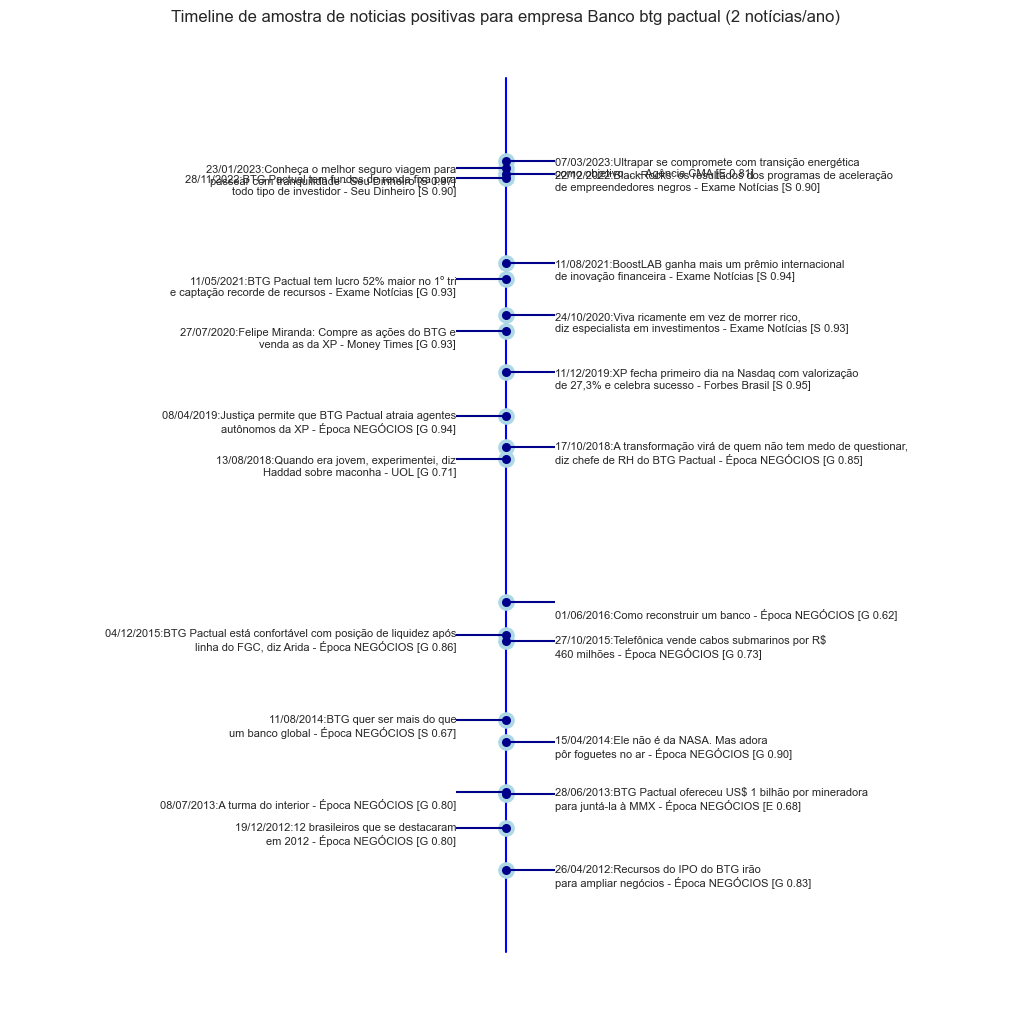

In [17]:
plota_timeline_polaridade(dfEmpresa, +1, 2, empresa )

16/04/2012: BTG confirma notificação de André Esteves na Itália - Época NEGÓCIOS [G -0.73]
22/10/2012: Em visita ao Brasil, Sarkozy se reúne com Dilma e Lula e analisa crise - Época NEGÓCIOS [S -0.84]
05/04/2015: Milionários brasileiros da lista do HSBC usavam paraísos fiscais - Época NEGÓCIOS [G -0.53]
27/11/2015: André Esteves é donode banco que Romárioteve conta na Suíça - Época NEGÓCIOS [G -0.08]
26/02/2016: Ex-executivo do BTG na Ásia conta como negligência na China está ligada a escândalo no Brasil - Forbes Brasil [G -0.71]
27/07/2016: Nelson Jobim será o responsável pelas relações institucionais do BTG - Época NEGÓCIOS [G -0.44]
19/04/2017: Juiz da Conclave quebra sigilo de André Esteves - Época NEGÓCIOS [G -0.85]
17/07/2017: EFG International e BTG Pactual chegam a acordo sobre preço final por BSI - Época NEGÓCIOS [G -0.28]
12/03/2018: André Esteves se prepara para voltar ao comando do BTG - Época NEGÓCIOS [G -0.69]
29/12/2018: Fundador do BTG Pactual volta a grupo de controle 

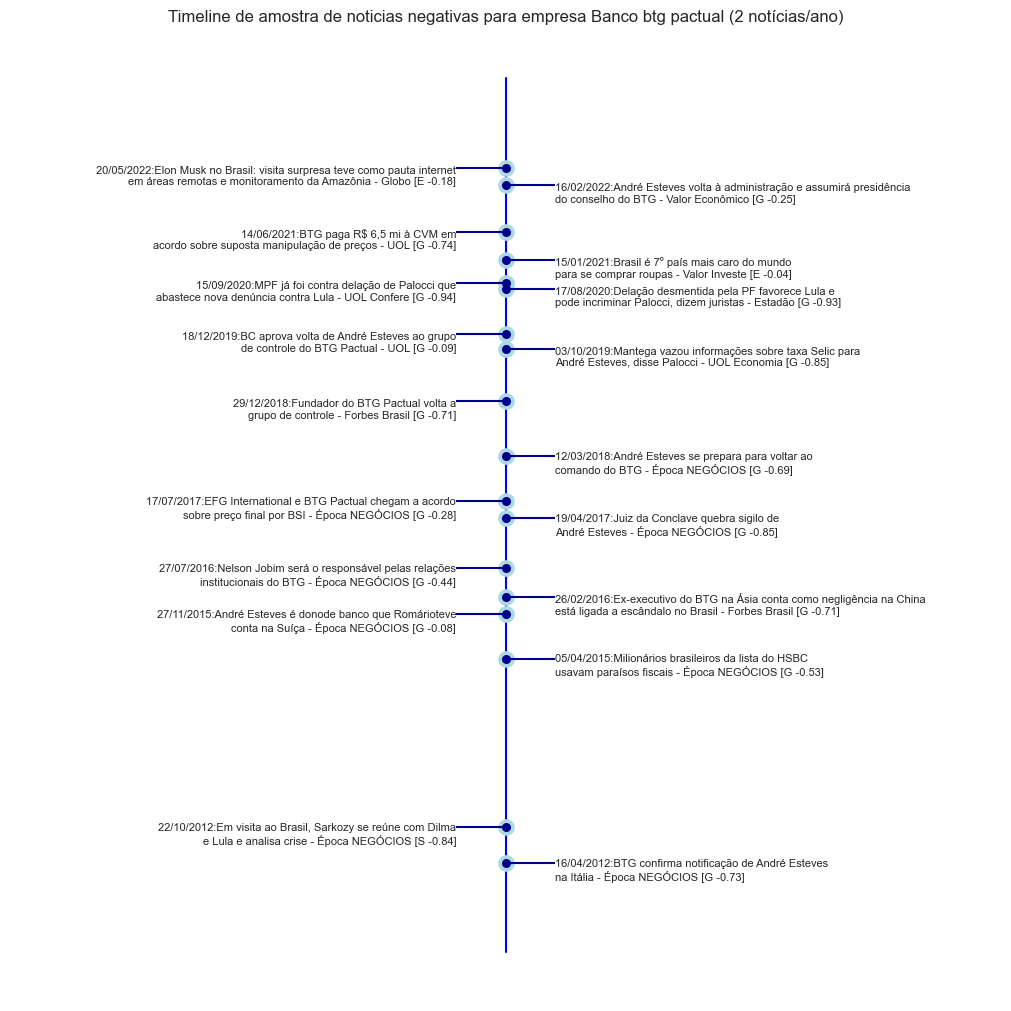

In [18]:
plota_timeline_polaridade(dfEmpresa, -1, 2, empresa )

## Comparativo entre empresas com mais notícias

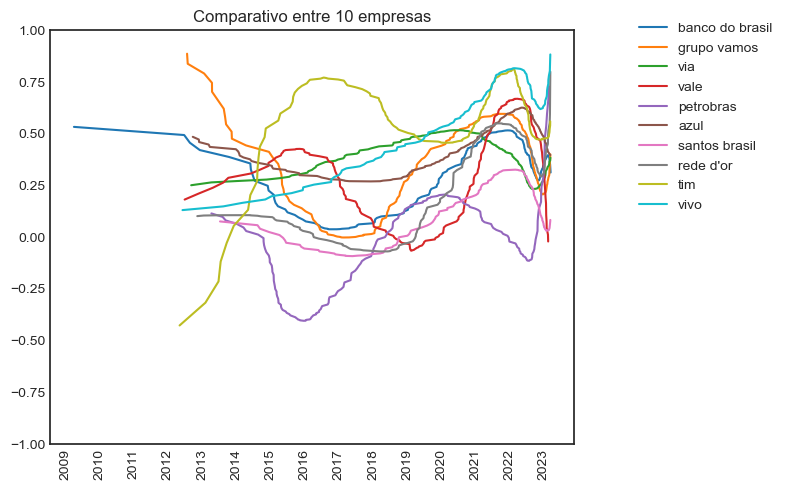

In [19]:
qtde_comparar = 10
lcomp = list(df.groupby("empresa").count().sort_values(by=['titulo'], ascending=False).reset_index(drop=False).head(qtde_comparar)['empresa'])

fig, ax = plt.subplots(figsize=(8,5))

for emp in lcomp:
    dfEmpPol = gera_curva_polaridade_media(df, emp, 'ESG')
    ax.plot(dfEmpPol.index, dfEmpPol['polaridade_fit'], label=emp,  linewidth=1.5)

    
# ajustando o visual do gráfico
ax.set_title('Comparativo entre '+str(len(lcomp))+' empresas', fontsize=12)
ax.xaxis.set_major_locator(YearLocator() )
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_minor_locator(MonthLocator())
ax.tick_params(axis='x', labelrotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.05), fancybox=True)

plt.tight_layout()
plt.ylim(-1, 1)
plt.show()


## Comparativo com Polaridade x B3

In [22]:
dfB3 = None

dfEmpresasComparar = pd.read_excel('datasets/lista_empresas.xlsx')

dfEmpresasComparar = pd.merge(left=dfEmpresasComparar, right=pd.read_excel('datasets/EscoreMerco.xlsx'), on='Nome', how='left')

data_analise = dt.date(2022, 12, 31)  # ate fim de 2022

dfAnalise = df[df['data_publicacao'].dt.date <= data_analise ]

dfEmpresasComparar = dfEmpresasComparar[ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) | (~pd.isnull(dfEmpresasComparar['Escore Merco']))  ]  # somente considera B3 ou MERCO

dfEmpresasComparar['QtdeNoticias'] =  dfEmpresasComparar.apply(lambda row: len(dfAnalise[dfAnalise.empresa == remove_acentos(row['Nome'].lower())]),  axis=1)

def obtem_ultima_polaridade_base100(dfAnalise, empresa, data_analise):
    dfRes = gera_curva_polaridade_media(dfAnalise, remove_acentos(empresa.lower()), 'ESG', data_analise)
    if dfRes is not None and len(dfRes) > 0:
        return 100.0 * dfRes['polaridade_fit'].iloc[-1]
    else:
        return None
    

dfEmpresasComparar['Polaridade'] = dfEmpresasComparar.apply(lambda row: obtem_ultima_polaridade_base100(dfAnalise, row['Nome'], data_analise) if row['QtdeNoticias'] >= 10 else None   , axis=1)

# B3 x pol
dfB3Pol = dfEmpresasComparar[['Nome', 'SCORE ISE B3', 'Polaridade']][ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) &  (~pd.isnull(dfEmpresasComparar['Polaridade'])) ].drop_duplicates()
print ("B3 x Polaridade (" + str(len(dfB3Pol)) + " empresas): " + str(scipy.stats.spearmanr(dfB3Pol['SCORE ISE B3'], dfB3Pol['Polaridade'])))

# MERCO x POL
dfMercoPol = dfEmpresasComparar[['Nome', 'Escore Merco', 'Polaridade']][ (~pd.isnull(dfEmpresasComparar['Escore Merco'])) &  (~pd.isnull(dfEmpresasComparar['Polaridade'])) ].drop_duplicates()
print ("Merco x Polaridade (" + str(len(dfMercoPol)) + " empresas): " + str(scipy.stats.spearmanr(dfMercoPol['Escore Merco'], dfMercoPol['Polaridade'])))


# B3 x MERCO
dfB3Merco = dfEmpresasComparar[['Nome', 'SCORE ISE B3', 'Escore Merco']][ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) &  (~pd.isnull(dfEmpresasComparar['Escore Merco'])) ].drop_duplicates()
print ("B3 x Merco (" + str(len(dfB3Merco)) + " empresas): " + str(scipy.stats.spearmanr(dfB3Merco['SCORE ISE B3'], dfB3Merco['Escore Merco'])))


# B3 x pol
dfB3Pol = dfEmpresasComparar[['Nome', 'SCORE ISE B3', 'Polaridade']][ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) &  (~pd.isnull(dfEmpresasComparar['Polaridade'])) ].drop_duplicates()
print ("B3 x Polaridade (" + str(len(dfB3Pol)) + " empresas): " + str(scipy.stats.pearsonr(dfB3Pol['SCORE ISE B3'], dfB3Pol['Polaridade'])))

# MERCO x POL
dfMercoPol = dfEmpresasComparar[['Nome', 'Escore Merco', 'Polaridade']][ (~pd.isnull(dfEmpresasComparar['Escore Merco'])) &  (~pd.isnull(dfEmpresasComparar['Polaridade'])) ].drop_duplicates()
print ("Merco x Polaridade (" + str(len(dfMercoPol)) + " empresas): " + str(scipy.stats.pearsonr(dfMercoPol['Escore Merco'], dfMercoPol['Polaridade'])))

# B3 x MERCO
dfB3Merco = dfEmpresasComparar[['Nome', 'SCORE ISE B3', 'Escore Merco']][ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) &  (~pd.isnull(dfEmpresasComparar['Escore Merco'])) ].drop_duplicates()
print ("B3 x Merco (" + str(len(dfB3Merco)) + " empresas): " + str(scipy.stats.pearsonr(dfB3Merco['SCORE ISE B3'], dfB3Merco['Escore Merco'])))


B3 x Polaridade (71 empresas): SpearmanrResult(correlation=0.29111334674714956, pvalue=0.01377707016426442)
Merco x Polaridade (32 empresas): SpearmanrResult(correlation=0.011730205278592375, pvalue=0.9491946977277163)
B3 x Merco (27 empresas): SpearmanrResult(correlation=0.0757020757020757, pvalue=0.7074481205870736)
B3 x Polaridade (71 empresas): PearsonRResult(statistic=0.28964846987504794, pvalue=0.014282899827745917)
Merco x Polaridade (32 empresas): PearsonRResult(statistic=0.012498524584902852, pvalue=0.9458716902803858)
B3 x Merco (27 empresas): PearsonRResult(statistic=-0.04558049029022741, pvalue=0.821393448682505)
